# Embedding graphs in Minkowski spacetime


> The views of space and time which I wish to lay before you have sprung from the soil of experimental physics, and therein lies their strength. They are radical. Henceforth space by itself, and time by itself, are doomed to fade away into mere shadows, and only a kind of union of the two will preserve an independent reality. — Hermann Minkowski, 1908

![title](../images/lightcone.svg.png)

#### **Implementation of Lorentzian graph embeddings:**

**[1]** Clough JR, Evans TS (2017) Embedding graphs in Lorentzian spacetime. PLoS ONE 12(11):e0187301. https://doi.org/10.1371/journal.pone.0187301<br>

The authors also released their own open-source Python library that can be found here: https://github.com/JamesClough/dagology

Despite the author's excellent and highly accessible code, I decided to attempt my own limited Python implementation to incorporate it within the format of my larger repository, and to potentially pursue implementing different variants of the MDS algorithm along with some newer packages like `NetworKit` that offer drastically better performance for the distance calculations on large networks.     

**Two Main Steps:**<br>
- Given some input DAG, we compute a pairwise dissimilarity matrix by estimating space-like and time-like distances, which we call separations. <br>
- Apply generalized, Lorentzian Multidimensional Scaling with this separation matrix as input


Given only pairwise separations $M_{ij}$, can we find coordinates in Minkowski spacetime that preserve these pairwise separations? The full spacetime embedding algorithm from **[1]** is summarized below:

<div class="alert alert-block alert-success">
<b>DAG Embedding Algorithm:</b> <br>
1. For every pair $i, j$ connected by an edge, find length of the longest directed path between them, $L_{i j}$<br>
2. For every other pair, find the naive spacelike distance $N_{i j}$ .<br>
3. Create separation matrix, M, such that $M_{i j}$ = $-L_{i j}^{2}$ if there is a path from $i$ to $j$ and
$N_{i j}^{2}$ otherwise.<br>
4. Use Lorentzian MDS with $\mathrm{M}$ as the input matrix of squared separations.<br>
</div>

In [68]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# plotting style
%matplotlib inline
plt.style.use('default')
# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
# ignore warnings
import warnings
warnings.filterwarnings('ignore');

### Visualizing causal sets & synthetic DAGs in Minkowski space

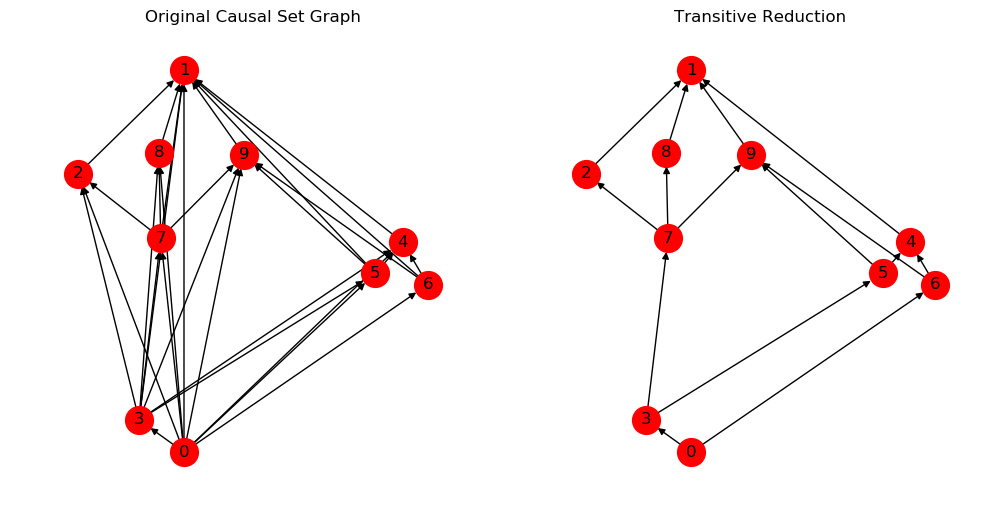

In [69]:
from sample_graphs import causal_set_graph, uniform_box_graph, random_dag

# plot causal set graph & transitive reduction
N = 10
G = causal_set_graph(N, 2)
options = {'node_size': 400,
           'width': 1,
           'with_labels': True}
draw_pos = {i:G.node[i]['position'][::-1] for i in range(N)}
trans_G = nx.transitive_reduction(G)
plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw(G, pos=draw_pos, **options)
plt.title('Original Causal Set Graph')
plt.subplot(122)
plt.title('Transitive Reduction')
nx.draw(trans_G, pos=draw_pos, **options);

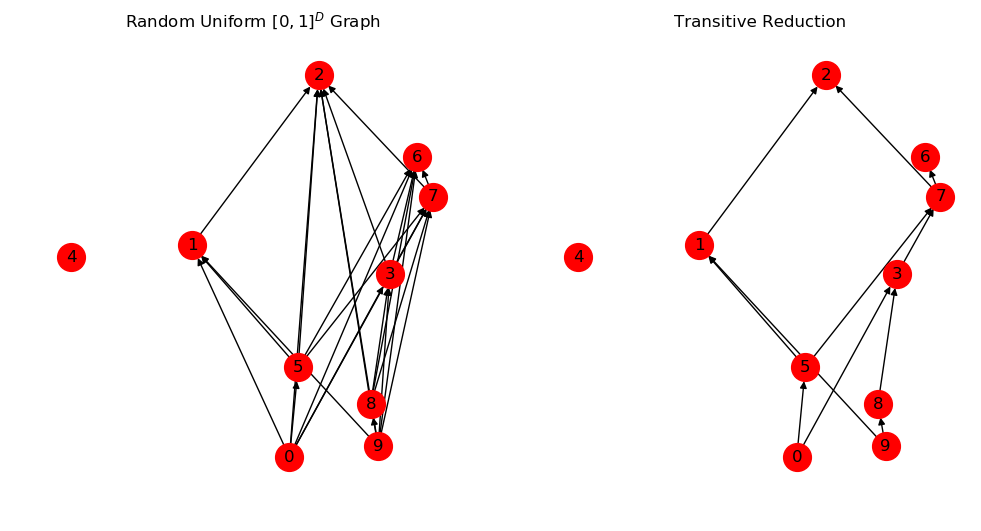

In [70]:
# plot uniform rectangle graph and transitive reduction
N = 10
G = uniform_box_graph(N, 2)
draw_pos = {i:G.node[i]['position'][::-1] for i in range(N)}
trans_G = nx.transitive_reduction(G)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(r'Random Uniform $[0,1]^D$ Graph')
nx.draw(G, pos=draw_pos, **options)
plt.subplot(122)
plt.title('Transitive Reduction')
nx.draw(trans_G, pos=draw_pos, **options);

# Evaluating Minkowski Graph Embeddings

We now attempt to apply this DAG embedding algorithm on real data, beginning with a few synthetic datasets: causal set graphs, uniformly scattered interval graphs, and Random DAGs. <br>

Finally, we apply the embedding to real world citation networks, such as the collection of directed citations existing between published scientific papers (from KDD 2003 data), as well as the network of citations documented between legal cases in the Supreme Court of the United States **[2]**<br>
<br>
**[2]** source: The Authority of Supreme Court Precedent James H. Fowler, Sangick Jeon Social Networks 30 (1): 16-30 (January 2008)

### Ex.) Causal set graphs

*Note: how to handle embeddings where time direction is reversed?*

In [71]:
from eval_metrics import add_edges, roc_auc_score, plot_roc_curve, sensitivity, specificity
from dag_embed import MinkowskiEmbedding
plt.style.use('default')
plt.style.use('seaborn')
def plot_embedding(G, X, title = 'Original input graph'):
    # use input graph and embedding to plot in 2-D Minkowski space
    N = X.shape[0]
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.title('Spacetime Embedding Recreation')
    plt.xlabel('Time')
    plt.ylabel('Space')
    plt.scatter(X[:, 0], X[:, 1], s=100, edgecolor='black', linewidth=1)
    # add node labels
    for i in range(N):
        _ = plt.text(X[i, 0]+0.03, X[i, 1]+0.03, str(i), size=14, fontweight='bold');
    # add edges to the plot
    for u,v in add_edges(X):
        _ = plt.plot([X[u][0], X[v][0]], [X[u][1], X[v][1]], c='red', linestyle='--', alpha=0.3);
    plt.subplot(122)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Space')
    X_orig = np.array([G.node[i]['position'] for i in range(N)])
    # plot original coordinates and edges from input graph (i.e. if input G = causal set) 
    plt.scatter(X_orig[:, 0], X_orig[:, 1], s=100, edgecolor='black', linewidth=1)
    for i in range(N):
        _ = plt.text(X_orig[i, 0]+0.01, X_orig[i, 1]+0.01, str(i), size=14, fontweight='bold');
    for u,v in list(G.edges()):
        _ = plt.plot([X_orig[u][0], X_orig[v][0]], [X_orig[u][1], X_orig[v][1]], 
                     alpha=0.3, c='red', linestyle='--');
    plt.show();

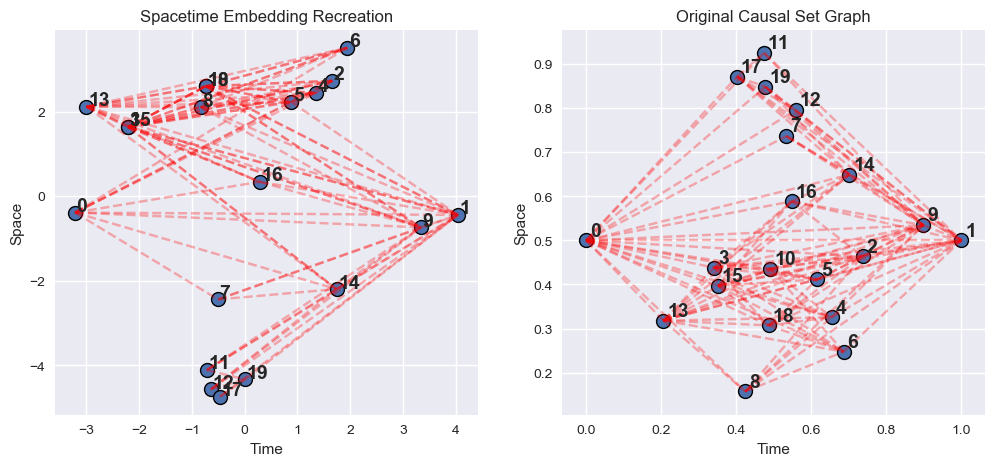

In [72]:
N = 20
G = causal_set_graph(N, 2)
causet_embed = MinkowskiEmbedding()
X = causet_embed.fit(G)
plot_embedding(G, X, title = 'Original Causal Set Graph')

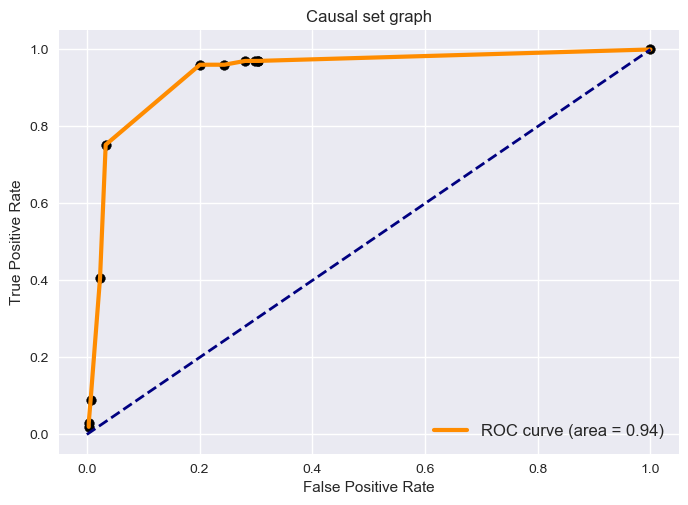

Sensitivity at c=1:  0.7524752475247525
Specificity at c=1:  0.9665551839464883


In [73]:
# plot roc curve
plot_roc_curve(G, X, title='Causal set graph')
print('Sensitivity at c=1: ', sensitivity(G, causet_embed.predict(G)))
print('Specificity at c=1: ', specificity(G, causet_embed.predict(G)));

## Ex.) Uniform Minkowski $[0,1]^{\mathbb{D}}$ Graph 

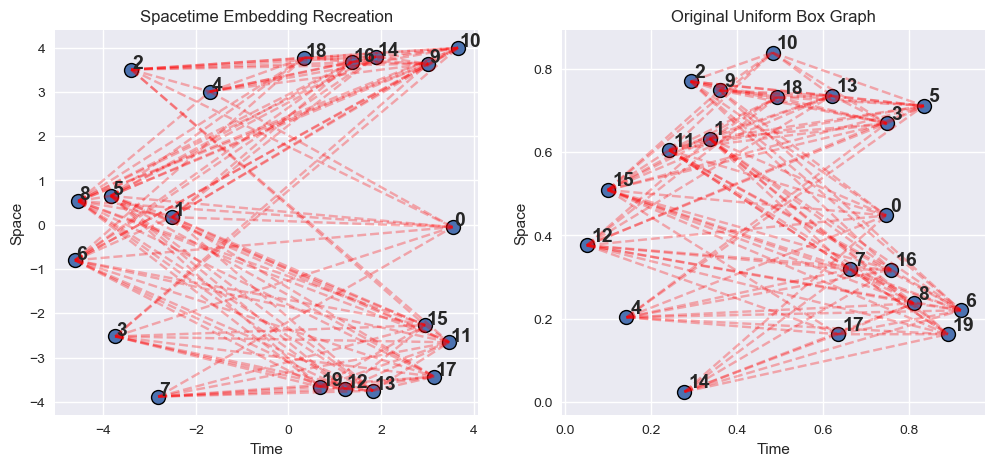

In [74]:
# evaluate on uniform box graph
N = 20
G = uniform_box_graph(N, 2)
uniform_embed = MinkowskiEmbedding()
X = uniform_embed.fit(G)
plot_embedding(G, X, title='Original Uniform Box Graph')

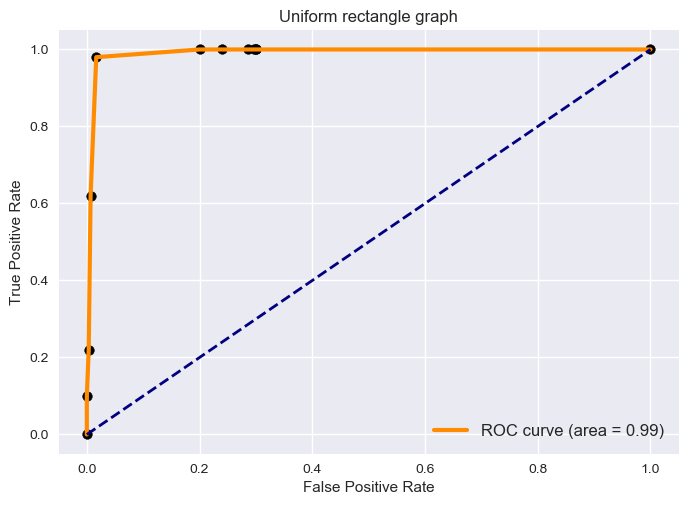

Sensitivity at c=1:  0.98
Specificity at c=1:  0.9833333333333333


In [75]:
# plot roc curve
plot_roc_curve(G, X, title='Uniform rectangle graph')
print('Sensitivity at c=1: ', sensitivity(G, uniform_embed.predict(G)))
print('Specificity at c=1: ', specificity(G, uniform_embed.predict(G)));

## Ex.) Minkowski Embedding of Random DAG

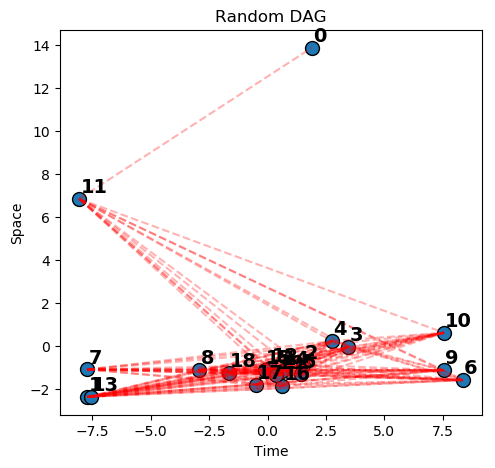

In [76]:
N = 20
G = random_dag(N)
random_embed = MinkowskiEmbedding(n_components=2) 
X = random_embed.fit(G)
plt.figure(figsize=(12,5))
plt.style.use('default')
plt.subplot(121)
plt.title('Random DAG')
plt.xlabel('Time')
plt.ylabel('Space')
plt.scatter(X[:, 0], X[:, 1], s=100, edgecolor='black', linewidth=1)
# add node labels
for i in range(N):
    _ = plt.text(X[i, 0]+0.05, X[i, 1]+0.3, str(i), size=14, fontweight='bold');
# add edges to the plot
for u,v in add_edges(X):
    _ = plt.plot([X[u][0], X[v][0]], [X[u][1], X[v][1]], c='red', linestyle='--', alpha=0.3);
plt.show();

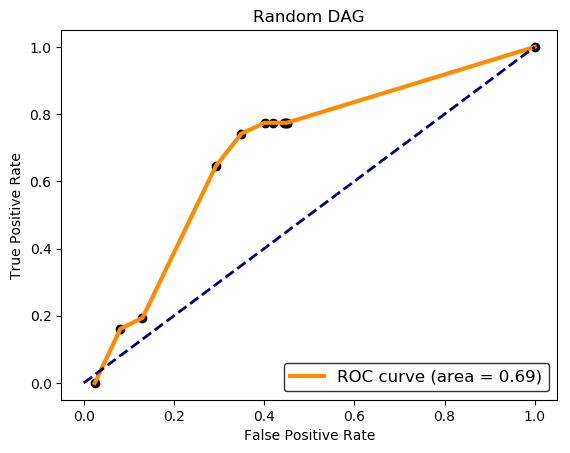

Sensitivity at c=1:  0.7419354838709677
Specificity at c=1:  0.6504065040650406


In [77]:
# plot roc curve
plot_roc_curve(G, X, title='Random DAG')
print('Sensitivity at c=1: ', sensitivity(G, random_embed.predict(G)))
print('Specificity at c=1: ', specificity(G, random_embed.predict(G)));

### Comparing sample graph embeddings

In [78]:
def evaluate_avg(graph_generator, num_nodes=20, num_trials=10):
    scores = []
    for i in range(num_trials):
        if graph_generator==random_dag:
            G = graph_generator(num_nodes, p=0.1)
            embed = MinkowskiEmbedding(n_components=2) 
            X = embed.fit(G)
            scores.append(roc_auc_score(G, X))
        else:
            G = graph_generator(num_nodes, 2)
            embed = MinkowskiEmbedding(n_components=2) 
            X = embed.fit(G)
            scores.append(roc_auc_score(G, X))
    return scores

In [79]:
causal_graph_scores = evaluate_avg(causal_set_graph)
uniform_graph_scores = evaluate_avg(uniform_box_graph)
random_dag_scores = evaluate_avg(random_dag)

# Ex.) Citation Networks

**arXiv physics paper citations: `hep-th`**

In [80]:
import pandas as pd
hep_df = pd.read_csv('../data/arxiv_citations/hep-th-citations.tar.gz', compression='gzip', dtype=str)
hep_df = hep_df.dropna()
hep_df['cited_from'] = hep_df['hep-th-citations'].apply(lambda x: str(x).split(' ')[0])
hep_df['cited_to'] = hep_df['hep-th-citations'].apply(lambda x: str(x).split(' ')[1])
hep_df = hep_df.iloc[:, 1:]
hep_df.head()

,cited_from,cited_to
0,0001001,9308122
1,0001001,9309097
2,0001001,9311042
3,0001001,9401139
4,0001001,9404151


In [81]:
slac_dates = pd.read_csv('../data/arxiv_citations/hep-th-slacdates.tar.gz', compression='gzip', dtype=str)
slac_dates = slac_dates.dropna()
slac_dates['arxiv_id'] = slac_dates['hep-th-slacdates'].apply(lambda x: str(x).split(' ')[0])
slac_dates['date'] = slac_dates['hep-th-slacdates'].apply(lambda x: str(x).split(' ')[1])
slac_dates = slac_dates.iloc[:, 1:]
slac_dates.head()
slac_dates.shape

,arxiv_id,date
0,0001002,2000-01-04
1,0001003,2000-01-04
2,0001004,2000-01-04
3,0001005,2000-01-04
4,0001006,2000-01-04


(29554, 2)

In [164]:
import datetime
N = 40
top_cited = list(hep_df.cited_to.value_counts()[:N].index)
edges = []
for node in top_cited:
    cited_by = hep_df.loc[hep_df.cited_to == node, 'cited_from'].values
    for x in cited_by:
        if x in top_cited:
            edges.append((x, node))

degree_dict = dict(zip(hep_df.cited_to.value_counts()[:N].index,
                       hep_df.cited_to.value_counts()[:N].values))
top_cited_df = slac_dates.loc[(slac_dates.arxiv_id.apply(lambda x: x in top_cited)), :]
top_cited_df = top_cited_df.reset_index(drop=True)
top_cited_df['degree'] = top_cited_df.arxiv_id.apply(lambda x: degree_dict[x])
top_cited_df['num_date'] = top_cited_df.date
top_cited_df['date_time'] = top_cited_df.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
top_cited_df['num_date'] = top_cited_df.date_time - np.min(top_cited_df.date_time)
top_cited_df['num_date'] = top_cited_df['num_date'].dt.days
top_cited_df['num_date'] = top_cited_df.num_date / np.max(top_cited_df.num_date)
date_dict = dict(zip(top_cited_df.arxiv_id.values, top_cited_df.num_date))

In [165]:
# build graph and fit embedding
G = nx.DiGraph()
for node in top_cited:
    G.add_node(node)
G.add_edges_from(edges)
embed = MinkowskiEmbedding(n_components=2)
X = embed.fit(G)

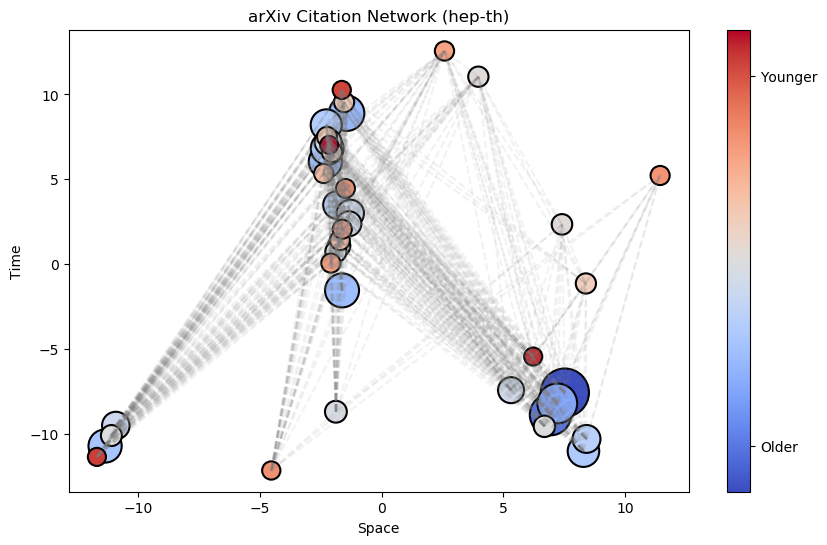

In [166]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.grid('off')
plt.title('arXiv Citation Network (hep-th)')
plt.ylabel('Time')
plt.xlabel('Space')
node_list = list(G.nodes())
node_colors = np.array(list(date_dict.values()))
node_sizes = np.array(list(degree_dict.values()))
# switch coords to place timelike coordinate on y-axis
im = plt.scatter(X[:, 1], X[:, 0], s = node_sizes/2, c = node_colors, cmap=plt.cm.coolwarm,
                vmin=0, vmax=1, edgecolor='black', linewidth=1.5)
for u,v in add_edges(X):
    _ = plt.plot([X[u][1], X[v][1]], [X[u][0], X[v][0]], c='gray', linestyle='--', alpha=0.1);
cbar = plt.colorbar(im);
cbar.set_ticks([0.1, 0.9]);
cbar.set_ticklabels(['Older', 'Younger'])
#plt.savefig('hep-th_citation_network.png')
plt.show();

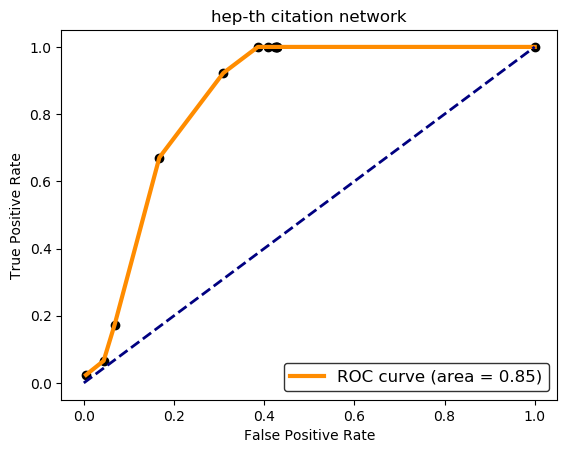

0.9221556886227545

0.6908583391486393

In [85]:
plot_roc_curve(G, X, title='hep-th citation network')
sensitivity(G, embed.predict(G))
specificity(G, embed.predict(G))
hep_th_score = roc_auc_score(G, X)

## SCOTUS Citation Network

In [91]:
scotus_df = pd.read_csv('../data/SCOTUS/allcites.txt', sep = ' ', header = None)
scotus_df.columns = ['cited_by_id', 'cited_id']
scotus_df.head()
scotus_df.shape
judicial_df = pd.read_csv('../data/SCOTUS/judicial.csv')
judicial_df.head()

,cited_by_id,cited_id
0,388,332
1,388,386
2,511,153
3,511,28
4,511,300


(216738, 2)

,caseid,usid,parties,year,overruled,overruling,oxford,liihc,indeg,outdeg,hub,hubrank,auth,authrank,between,incent
0,1,1US1,NaN,1754,0,0,0,0,0,0,0.0,20250,0.000000,20945,0.0,0.000000
1,2,1US2,NaN,1759,0,0,0,0,0,0,0.0,20250,0.000000,20945,0.0,0.000000
2,3,1US3,NaN,1760,0,0,0,0,0,0,0.0,20250,0.000000,20945,0.0,0.000000
3,4,1US4,NaN,1760,0,0,0,0,0,0,0.0,20250,0.000000,20945,0.0,0.000000
4,5,1US5,NaN,1762,0,0,0,0,1,0,0.0,20250,0.000029,15507,0.0,0.038877


In [154]:
# select only top N most cited cases
N = 50
top_cited = list(scotus_df.cited_id.value_counts()[:N].index)
edges = []
for node in top_cited:
    cited_by_id = scotus_df.loc[scotus_df.cited_id == node, 'cited_by_id'].values
    for x in cited_by_id:
        if x in top_cited:
            edges.append((x, node))

degree_dict = dict(zip(scotus_df.cited_id.value_counts()[:N].index,
                       scotus_df.cited_id.value_counts()[:N].values))

top_cited_df = judicial_df.loc[(judicial_df.caseid.apply(lambda x: x in top_cited)), :]
top_cited_df = top_cited_df.reset_index(drop=True)
top_cited_df['degree'] = top_cited_df.caseid.apply(lambda x: degree_dict[x])
top_cited_df['num_date'] = top_cited_df.year - np.min(top_cited_df.year)
#top_cited_df['num_date'] = top_cited_df.num_date / np.max(top_cited_df.num_date)
top_cited_df['num_date'] = (top_cited_df.num_date - np.mean(top_cited_df.num_date)) / np.std(top_cited_df.num_date)
date_dict = dict(zip(top_cited_df.caseid.values, top_cited_df.num_date))
name_dict = dict(zip(top_cited_df.caseid.values, top_cited_df.parties.values))
top_cited_df.head()

,caseid,usid,parties,year,overruled,overruling,oxford,liihc,indeg,outdeg,hub,hubrank,auth,authrank,between,incent,degree,num_date
0,1016,17US316,McCulloch v. Maryland,1819,0,0,1,1,198,0,0.000000,20250,0.029660,188,0.000000,0.171621,196,-3.256212
1,1156,22US1,Gibbons v. Ogden,1824,0,0,1,1,156,0,0.000000,20250,0.014221,582,0.000000,0.164436,156,-3.119051
2,1195,22US738,"Osborn v. President, Directors & Co. of Bank",1824,7907,0,1,0,112,0,0.000000,20250,0.005356,1647,0.000000,0.159238,112,-3.119051
3,7417,116US616,Boyd v. United States,1886,0,0,1,0,130,1,0.000004,18427,0.043477,103,0.000013,0.142113,130,-1.418249
4,10465,166US226,"Chicago, B. & Q. R. Co. v. Chicago",1897,0,0,1,0,112,32,0.002909,3124,0.026381,236,0.001208,0.145005,112,-1.116494


In [155]:
# build input graph and fit the embedding
G = nx.DiGraph()
for node in top_cited:
    G.add_node(node)
G.add_edges_from(edges)
embed = MinkowskiEmbedding(n_components=2)
X = embed.fit(G)

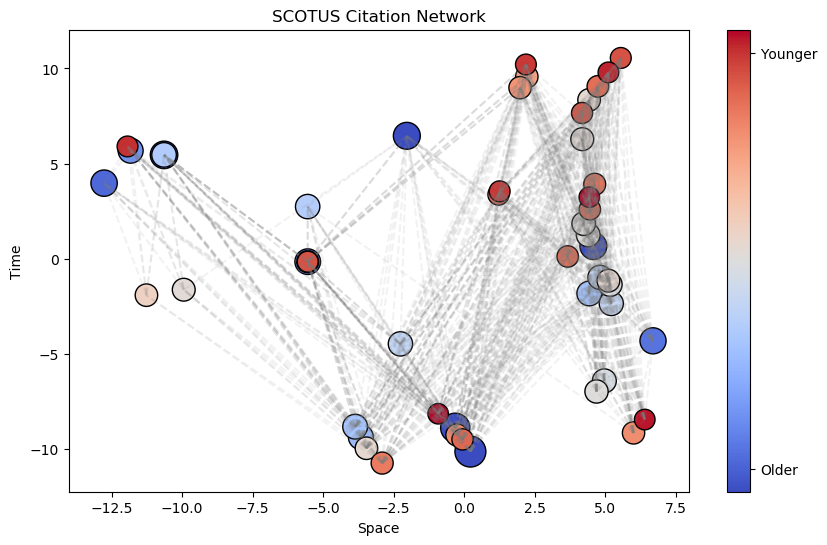

In [160]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.grid('off')
plt.title('SCOTUS Citation Network')
plt.ylabel('Time')
plt.xlabel('Space')
node_list = list(G.nodes())
node_colors = np.array(list(date_dict.values()))
node_sizes = np.array(list(degree_dict.values()))
node_names = np.array(list(name_dict.values()))
for u,v in add_edges(X):
    _ = plt.plot([X[u][1], X[v][1]], [X[u][0], X[v][0]], c='gray', linestyle='--', alpha=0.1);
im = plt.scatter(X[:, 1], X[:, 0], s = 2*node_sizes, c = node_colors, cmap=plt.cm.coolwarm,
                vmin=-1, vmax=1, edgecolor='black', linewidth=1)
cbar = plt.colorbar(im);
cbar.set_ticks([-0.9, 0.9]);
cbar.set_ticklabels(['Older', 'Younger'])
#plt.savefig('SCOTUS_citation_network.png')
plt.show();

0.9130434782608695

0.7507481829841812

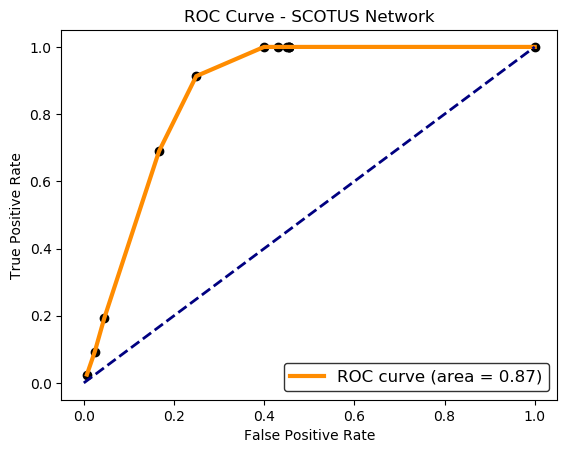

In [161]:
sensitivity(G, embed.predict(G))
specificity(G, embed.predict(G))
plot_roc_curve(G, X, title='ROC Curve - SCOTUS Network')
scotus_score = roc_auc_score(G, X)

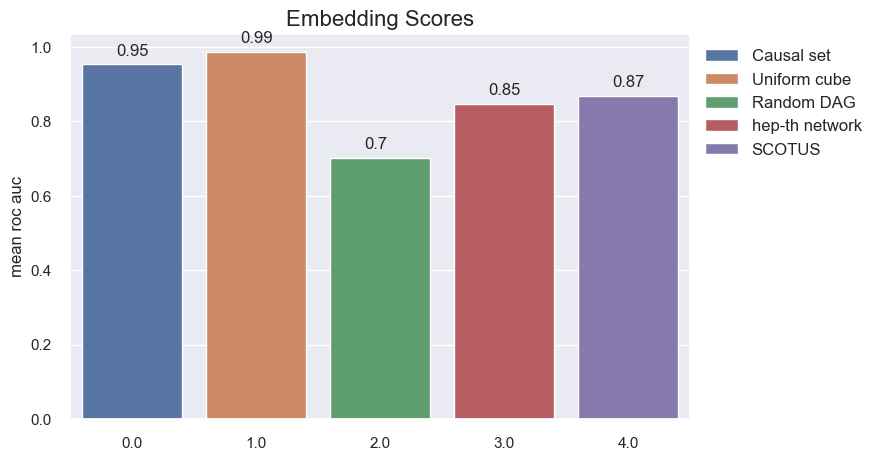

In [162]:
overall_scores = [causal_graph_scores, uniform_graph_scores, random_dag_scores, hep_th_score, scotus_score]
# prepare dataframe for use with sns.barplot
cite_scores = pd.DataFrame([[3, hep_th_score],[4, scotus_score]], columns=['dataset', 'roc_auc'])
test_dataset = list(np.repeat(0, len(causal_graph_scores)))
test_dataset += list(np.repeat(1, len(uniform_graph_scores)))
test_dataset += list(np.repeat(2, len(random_dag_scores)))
test_scores = list(causal_graph_scores) + list(uniform_graph_scores) + list(random_dag_scores)
result_df = pd.DataFrame(np.hstack((np.array(test_dataset).reshape(-1,1), np.array(test_scores).reshape(-1,1))),
                        columns=['dataset', 'roc_auc'])
result_df = pd.concat([result_df, cite_scores], ignore_index=True)
plt.figure(figsize=(8,5))
plt.style.use('seaborn')
sns.set(style="darkgrid")
ax = sns.barplot(data=result_df, x='dataset', y='roc_auc', hue='dataset', dodge=False, ci=None);
ax.set_title('Embedding Scores', size=16)
ax.set_ylabel('mean roc auc')
ax.set_xlabel(None)
# add values onto barplot display
for i, score in enumerate(overall_scores):
    ax.text(i-0.125, np.mean(score)+0.025, str(np.round(np.mean(score), 2)))
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Causal set", "Uniform cube", 'Random DAG', 'hep-th network', 'SCOTUS'],
          fontsize=12, loc='best', bbox_to_anchor=(1, 1));
 
plt.show();